In [2]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats, io

BIDS_path= "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

def get_coords_df_from_vhdr(vhdr_file, BIDS_path):
    """
    given a vhdr file path and the BIDS path
    :return a pandas dataframe of that session (important: not for the run; run channls might have only a s
    subset of all channels in the coordinate file)
    """
    subject = vhdr_file[vhdr_file.find('sub-')+4:vhdr_file.find('sub-')+7]

    if vhdr_file.find('right') !=-1:
        sess = 'right'
    else:
        sess = 'left'
    coord_path = os.path.join(BIDS_path, 'sub-'+ subject, 'ses-'+ sess, 'ieeg', 'sub-'+ subject+ '_electrodes.tsv')
    df = pd.read_csv(coord_path, sep="\t")
    return df

def get_all_vhdr_files(BIDS_path):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(".vhdr"):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_file

def get_coords(sub, sess_, str_loc="ECOG"):
    coord_path = os.path.join(BIDS_path, 'sub-'+ sub, 'ses-'+ sess_, 'ieeg', 'sub-'+ sub+ '_electrodes.tsv')
    df = pd.read_csv(coord_path, sep="\t")
    return np.array(df[df["name"].str.contains(str_loc) & 
                       df["name"].str.contains(sess_.upper())][["x", "y", "z"]])

def get_c_coord(sub, loc, lat, PATH_):
    
    res_files = os.listdir(PATH_)
    files = [f for f in res_files if (sub in f) and (loc in f)]

    res = np.load(os.path.join(PATH_, files[0]), allow_pickle=True).tolist()
    sess_ = files[0][files[0].find("ses-")+4:files[0].find(".npy")]
    if loc == "ECOG":
        coord_ = get_coords(sub, sess_, "ECOG")
        max_ = res["score_te"][lat]
        if sub == "006": coord_ = coord_[:max_.shape[0],:] 
    else: # STN
        max_ = res["score_te"][lat]
        max_ = [max_[0], (max_[0]+max_[1])/2, (max_[1]+max_[2])/2, max_[2]]
        coord_ = get_coords(sub, sess_, "STN")
    if len(files) > 1:
        res = np.load(os.path.join(PATH_, files[1]), allow_pickle=True).tolist()
        sess_ = files[1][files[1].find("ses-")+4:files[1].find(".npy")]
        if loc == "ECOG":
            coord_new_sess = get_coords(sub, sess_, "ECOG")
            max_ = np.concatenate((max_, res["score_te"][lat]), axis=0)
            if sub == "006": coord_new_sess = coord_new_sess[:res["score_te"][lat].shape[0],:] 
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
        else: # STN 
            max_one = res["score_te"][lat]
            max_one = [max_one[0], (max_one[0]+max_one[1])/2, (max_one[1]+max_one[2])/2, max_one[2]]
            max_ = np.concatenate((max_, max_one), axis=0)
            coord_ = np.concatenate((coord_, get_coords(sub, sess_, "STN")), axis=0)
    return max_, coord_

def get_c_coord_SPOC(sub, loc, lat, PATH_):
    """
    Here the mean of each test fold performance is taken and repeated for every channel 
    """
    
    res_files = os.listdir(PATH_)
    files = [f for f in res_files if (sub in f) and (loc in f) and ("tlag" in f)]

    res = np.load(os.path.join(PATH_, files[0]), allow_pickle=True).tolist()
    sess_ = files[0][files[0].find("ses-")+4:files[0].find(".npy")]
    if loc == "ECOG":
        coord_ = get_coords(sub, sess_, "ECOG")
        max_ = np.array([np.mean(res["score_te"][lat]) for i in range(coord_.shape[0])])
        #if sub == "006": coord_ = coord_[:max_.shape[0],:] 
    else: # STN
        coord_ = get_coords(sub, sess_, "STN")
        max_ = np.array([np.mean(res["score_te"][lat]) for i in range(coord_.shape[0])])
        
    if len(files) > 1:
        res = np.load(os.path.join(PATH_, files[1]), allow_pickle=True).tolist()
        sess_ = files[1][files[1].find("ses-")+4:files[1].find(".npy")]
        if loc == "ECOG":
            coord_new_sess = get_coords(sub, sess_, "ECOG")
            max_new_sess = np.array([np.mean(res["score_te"][lat]) for i in range(coord_new_sess.shape[0])])
            max_ = np.concatenate((max_, max_new_sess), axis=0)
            #if sub == "006": coord_new_sess = coord_new_sess[:28,:] 
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
        else: # STN 
            coord_new_sess = get_coords(sub, sess_, "STN")
            max_one = np.array([np.mean(res["score_te"][lat]) for i in range(coord_new_sess.shape[0])])
            max_ = np.concatenate((max_, max_one), axis=0)
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
    return max_, coord_

In [85]:
# get for ECOG and STN get beginning with sess right, coordinates, performance, distance
PATH_XGB = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\XGB_Out\\"
df = pd.DataFrame()
for loc in ["ECOG", "STN"]:
    for sub in subjects:
        res_files = os.listdir(PATH_XGB)
        files = [f for f in res_files if (sub in f) and (loc in f)]
        for file in files:
            res = np.load(os.path.join(PATH_XGB, file), allow_pickle=True).tolist()
            sess_ = file[file.find("ses-")+4:file.find(".npy")]
            #if loc == "ECOG":
            coord_ = get_coords(sub, sess_, loc)
            if sess_ == "right" and sub == "006":
                coord_ = coord_[:28,:]
            if loc == "STN":
                coord_ = coord_[:3,:]
            if sess_ == 'right':
                knob_ecog = np.array([37, -25, 64])
                knob_stn = np.array([12.58, -13.41, -5.87])
            else:
                knob_ecog = np.array([-37, -25, 64])
                knob_stn = np.array([-12.58, -13.41, -5.87])
            for coord in range(coord_.shape[0]):
                ch_ = loc+"_"+sess_.upper()+"_"+str(coord)
                c_con = res["score_te"]["CON"][coord]
                c_ips = res["score_te"]["IPS"][coord]

                if loc == "ECOG":
                    dist_con = np.linalg.norm(coord_[coord,:] - knob_ecog)
                    dist_ips = np.linalg.norm(coord_[coord,:] - knob_ecog)
                else:
                    dist_con = np.linalg.norm(coord_[coord,:] - knob_stn)
                    dist_ips = np.linalg.norm(coord_[coord,:] - knob_stn)

                df = df.append({"sub":sub, "sess_":sess_, "loc":loc, "r2_con":c_con, "r2_ips":c_ips,
                          "dist_con":dist_con, "dist_ips":dist_ips, "x":coord_[coord,0],
                               "y":coord_[coord,1], "z":coord_[coord, 2], 
                               "ch":ch_}, ignore_index=True)
df_all = df            

In [86]:
df_all

,ch,dist_con,dist_ips,loc,r2_con,r2_ips,sess_,sub,x,y,z
0,ECOG_RIGHT_0,23.714756,23.714756,ECOG,0.665374,0.415182,right,000,37.318174,-48.610127,61.797655
1,ECOG_RIGHT_1,12.718657,12.718657,ECOG,0.701001,0.427649,right,000,40.159894,-37.315930,64.311716
2,ECOG_RIGHT_2,4.524949,4.524949,ECOG,0.549859,0.318156,right,000,40.943036,-27.217785,64.095184
3,ECOG_RIGHT_3,8.466679,8.466679,ECOG,0.598082,0.395837,right,000,39.783955,-17.005231,63.866181
4,ECOG_RIGHT_4,19.792789,19.792789,ECOG,0.541934,0.277476,right,000,39.688136,-5.528025,61.682543
...,...,...,...,...,...,...,...,...,...,...,...
243,STN_LEFT_1,6.166394,6.166394,STN,0.000000,0.000000,left,013,-14.888300,-17.947000,-9.350200
244,STN_LEFT_2,4.984300,4.984300,STN,0.000000,0.000000,left,013,-15.504000,-17.212900,-7.223300
245,STN_RIGHT_0,3.085589,3.085589,STN,0.000000,0.000000,right,014,14.812955,-14.134391,-3.867494
246,STN_RIGHT_1,4.695180,4.695180,STN,0.000000,0.004868,right,014,15.164177,-13.053698,-1.966183


In [87]:
def get_best_df(df, loc="ECOG", mod="CON"):
    df_best = pd.DataFrame()
    for sub in subjects:
        for sess_ in ["right", "left"]:
            df_ = df_all[df_all.sess_.str.contains(sess_) & ((df_all["sub"].astype(str) == sub) 
              & (df_all["loc"] == loc))]
            if df_.shape[0] == 0: continue
            if mod == "CON":
                df_best = df_best.append(df_.loc[df_["r2_con"].argmax()], ignore_index=True)
            else:
                df_best = df_best.append(df_.loc[df_["r2_ips"].argmax()], ignore_index=True)
    return df_best

In [169]:
df_best_ECOG_CON = get_best_df(df_all, loc="ECOG", mod="CON")
df_best_ECOG_IPS = get_best_df(df_all, loc="ECOG", mod="IPS")
df_best_STN_CON = get_best_df(df_all, loc="STN", mod="CON")
df_best_STN_IPS = get_best_df(df_all, loc="STN", mod="IPS")

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if __name__ == '__main__':
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  # This is added back by InteractiveShellApp.init_path()


In [170]:
df_best_ECOG_CON

,b_peak,ch,dist_con,dist_ips,loc,r2_con,r2_ips,sess_,sub,x,y,z
0,4.356077,ECOG_RIGHT_1,12.718657,12.718657,ECOG,0.701001,0.427649,right,000,40.159894,-37.315930,64.311716
1,2.586582,ECOG_RIGHT_19,5.723889,5.723889,ECOG,0.623992,0.091726,right,001,36.636654,-26.376084,69.544121
2,2.267635,ECOG_LEFT_6,52.237247,52.237247,ECOG,0.478258,0.145003,left,001,-37.145195,-34.718589,115.325022
3,3.046997,ECOG_RIGHT_4,11.855356,11.855356,ECOG,0.152820,0.378910,right,004,48.707572,-23.266782,63.308498
4,3.437339,ECOG_LEFT_2,21.240110,21.240110,ECOG,0.034297,0.065276,left,004,-27.428935,-38.945336,76.847746
5,2.405929,ECOG_RIGHT_5,27.893679,27.893679,ECOG,0.063336,0.022135,right,005,59.336262,-13.182007,52.189677
6,3.511697,ECOG_LEFT_6,37.761465,37.761465,ECOG,0.315690,0.099181,left,005,-45.922228,-61.416110,59.506786
7,3.864178,ECOG_RIGHT_18,16.440420,16.440420,ECOG,0.383311,0.024976,right,006,35.443243,-9.051098,67.673748
8,3.462273,ECOG_LEFT_29,28.211567,28.211567,ECOG,0.348631,0.038632,left,006,-61.086246,-24.967767,49.311766
9,2.574121,ECOG_LEFT_2,10.126506,10.126506,ECOG,0.036569,0.041408,left,007,-36.709111,-14.916705,64.888071


####  insert beta peaks for best channel 

In [171]:
def insert_beta_peakpowersum(df_ = df_best_ECOG_CON, loc="ECOG"):
    df_out = pd.read_pickle(os.path.join(PATH_ap, 'NOISE_ap_spectrum.p'))
    b_peaks = []
    for sub in subjects:
        for sess_ in ["right", "left"]:
            if df_[df_.sess_.str.contains(sess_) & ((df_["sub"].astype(str) == sub) 
                          & (df_["loc"] == loc))]["ch"].shape[0] == 0:
                continue
            ch = df_[df_.sess_.str.contains(sess_) & ((df_["sub"].astype(str) == sub) 
                          & (df_["loc"] == loc))]["ch"].values[0]
            b_peaks.append(df_out[df_out.hemisphere.str.contains(sess_.upper()) 
                          & (df_out["sub"].astype(str) == sub) 
                          & (df_out["channel"] == ch)]["beta_peak"].values[0])
    df_["b_peak"] = b_peaks
    return df_ 

In [172]:
df_best_ECOG_CON = insert_beta_peakpowersum(df_best_ECOG_CON, "ECOG")
df_best_ECOG_IPS = insert_beta_peakpowersum(df_best_ECOG_IPS, "ECOG")
df_best_STN_CON = insert_beta_peakpowersum(df_best_STN_CON, "STN")
df_best_STN_IPS = insert_beta_peakpowersum(df_best_STN_IPS, "STN")

#### insert beta power for all df 

In [173]:
b_peak = []
for index, row in df_all.iterrows():
    b_peak.append(df_out[df_out.hemisphere.str.contains(row["sess_"].upper()) 
                      & (df_out["sub"].astype(str) == row["sub"]) 
                      & (df_out["channel"] == row["ch"])]["beta_peak"].values[0])
df_all["b_peak"] = b_peak
    

In [174]:
df_best_ECOG_CON

,b_peak,ch,dist_con,dist_ips,loc,r2_con,r2_ips,sess_,sub,x,y,z
0,4.356077,ECOG_RIGHT_1,12.718657,12.718657,ECOG,0.701001,0.427649,right,000,40.159894,-37.315930,64.311716
1,2.586582,ECOG_RIGHT_19,5.723889,5.723889,ECOG,0.623992,0.091726,right,001,36.636654,-26.376084,69.544121
2,2.267635,ECOG_LEFT_6,52.237247,52.237247,ECOG,0.478258,0.145003,left,001,-37.145195,-34.718589,115.325022
3,3.046997,ECOG_RIGHT_4,11.855356,11.855356,ECOG,0.152820,0.378910,right,004,48.707572,-23.266782,63.308498
4,3.437339,ECOG_LEFT_2,21.240110,21.240110,ECOG,0.034297,0.065276,left,004,-27.428935,-38.945336,76.847746
5,2.405929,ECOG_RIGHT_5,27.893679,27.893679,ECOG,0.063336,0.022135,right,005,59.336262,-13.182007,52.189677
6,3.511697,ECOG_LEFT_6,37.761465,37.761465,ECOG,0.315690,0.099181,left,005,-45.922228,-61.416110,59.506786
7,3.864178,ECOG_RIGHT_18,16.440420,16.440420,ECOG,0.383311,0.024976,right,006,35.443243,-9.051098,67.673748
8,3.462273,ECOG_LEFT_29,28.211567,28.211567,ECOG,0.348631,0.038632,left,006,-61.086246,-24.967767,49.311766
9,2.574121,ECOG_LEFT_2,10.126506,10.126506,ECOG,0.036569,0.041408,left,007,-36.709111,-14.916705,64.888071


#### insert UPDRS values

In [185]:
#from https://docs.google.com/spreadsheets/d/1TUx5J9LAKUherd6QLGKew0orTxXViefJlu3VMQLWOeQ/edit#gid=0
    
UPDRS_rigidity_upper_extrimity_contralateral = [1,2,1,2,2,1,2,1,3,3,2,3,2,3,3,1]
UPDRS_rigidity_upper_extrimity_ipsilateral = [1,1,2,2,2,2,1,3,1,2,3,2,3,2,2,2]
UPDRS_combined_akinesia_rigidty_contalateral = [6,7,5,12,13,3,8,8,15,16,16,17.5,15,16,17,6]
UPDRS_combined_akinesia_rigidty_ipsilateral = [7,5,7,13,12,8,3,13,7,12,18,12,16,15,12,8]
UPDRS_total = [28,27,27,33,33, 31,31,32,32,52,55,50,62,62,48,31]

In [190]:
for df_ in [df_best_ECOG_CON, df_best_ECOG_IPS, df_best_STN_CON, df_best_STN_IPS]:
    df_["UPDRS_rigidity_upper_extrimity_contralateral"] = UPDRS_rigidity_upper_extrimity_contralateral
    df_["UPDRS_rigidity_upper_extrimity_ipsilateral"] = UPDRS_rigidity_upper_extrimity_ipsilateral
    df_["UPDRS_combined_akinesia_rigidty_contalateral"] = UPDRS_combined_akinesia_rigidty_contalateral
    df_["UPDRS_combined_akinesia_rigidty_ipsilateral"] = UPDRS_combined_akinesia_rigidty_ipsilateral
    df_["UPDRS_total"] = UPDRS_total

In [223]:
UPDRS_rigidity_upper_extrimity_contralateral_ = []
UPDRS_rigidity_upper_extrimity_ipsilateral_ = []
UPDRS_combined_akinesia_rigidty_contalateral_ = []
UPDRS_combined_akinesia_rigidty_ipsilateral_ = []
UPDRS_total_ = []
for index, row in df_all.iterrows():
    UPDRS_rigidity_upper_extrimity_contralateral_.append(df_best_ECOG_CON[df_best_ECOG_CON.sess_.str.contains(row["sess_"]) 
                      & (df_best_ECOG_CON["sub"].astype(str) == row["sub"])]["UPDRS_rigidity_upper_extrimity_contralateral"].values[0])
    
    UPDRS_rigidity_upper_extrimity_ipsilateral_.append(df_best_ECOG_CON[df_best_ECOG_CON.sess_.str.contains(row["sess_"]) 
                      & (df_best_ECOG_CON["sub"].astype(str) == row["sub"]) 
                      ]["UPDRS_rigidity_upper_extrimity_ipsilateral"].values[0])

    UPDRS_combined_akinesia_rigidty_contalateral_.append(df_best_ECOG_CON[df_best_ECOG_CON.sess_.str.contains(row["sess_"]) 
                      & (df_best_ECOG_CON["sub"].astype(str) == row["sub"])]["UPDRS_combined_akinesia_rigidty_contalateral"].values[0])

    UPDRS_combined_akinesia_rigidty_ipsilateral_.append(df_best_ECOG_CON[df_best_ECOG_CON.sess_.str.contains(row["sess_"]) 
                      & (df_best_ECOG_CON["sub"].astype(str) == row["sub"])]["UPDRS_combined_akinesia_rigidty_ipsilateral"].values[0])

    UPDRS_total_.append(df_best_ECOG_CON[df_best_ECOG_CON.sess_.str.contains(row["sess_"]) 
                      & (df_best_ECOG_CON["sub"].astype(str) == row["sub"])]["UPDRS_total"].values[0])



df_all["UPDRS_rigidity_upper_extrimity_contralateral"] = UPDRS_rigidity_upper_extrimity_contralateral_
df_all["UPDRS_rigidity_upper_extrimity_ipsilateral"] = UPDRS_rigidity_upper_extrimity_ipsilateral_
df_all["UPDRS_combined_akinesia_rigidty_contalateral"] = UPDRS_combined_akinesia_rigidty_contalateral_
df_all["UPDRS_combined_akinesia_rigidty_ipsilateral"] = UPDRS_combined_akinesia_rigidty_ipsilateral_
df_all["UPDRS_total"] = UPDRS_total_


In [228]:
df_all.to_csv('df_all.csv')
df_best_ECOG_CON.to_csv('df_ECOG_CON.csv')
df_best_ECOG_IPS.to_csv('df_ECOG_IPS.csv')
df_best_STN_CON.to_csv('df_STN_CON.csv')
df_best_STN_IPS.to_csv('df_STN_IPS.csv')

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


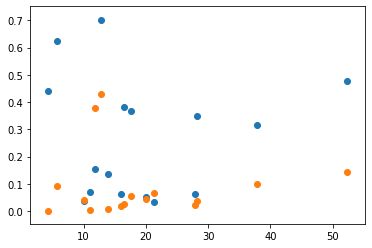

In [175]:
df_comp = df_best_ECOG_CON[df_all["loc"] == "ECOG"]
plt.scatter(df_comp["dist_con"], df_comp["r2_con"])
plt.scatter(df_comp["dist_con"], df_comp["r2_ips"])

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


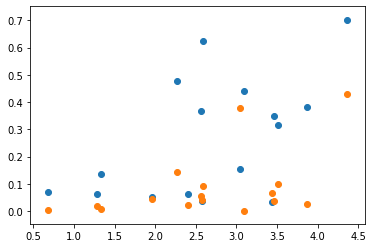

In [176]:
df_comp = df_best_ECOG_CON[df_all["loc"] == "ECOG"]
plt.scatter(df_comp["b_peak"], df_comp["r2_con"])
plt.scatter(df_comp["b_peak"], df_comp["r2_ips"])

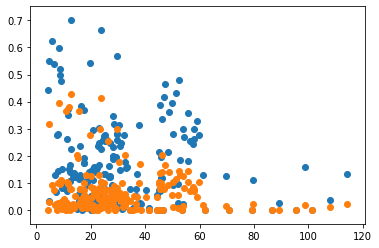

In [163]:
df_comp = df_all[df_all["loc"] == "ECOG"]
plt.scatter(df_comp["dist_con"], df_comp["r2_con"])
plt.scatter(df_comp["dist_con"], df_comp["r2_ips"])

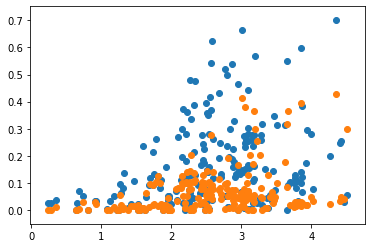

In [177]:
df_comp = df_all[df_all["loc"] == "ECOG"]
plt.scatter(df_comp["b_peak"], df_comp["r2_con"])
plt.scatter(df_comp["b_peak"], df_comp["r2_ips"])